In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import glob

import cv2
from sklearn.model_selection import train_test_split

## Loading data into 3 dataframes with labels using pandas

In [3]:
df_sit = pd.DataFrame(
   { 'image': glob.glob('C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/1200_images_dataset/sitting_1200/*') ,
    'label': 'sitting'}
)
df_stand = pd.DataFrame(
   { 'image': glob.glob('C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/1200_images_dataset/standing_1200/*') ,
    'label': 'standing'}
)

df_other = pd.DataFrame(
   { 'image': glob.glob('C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/1200_images_dataset/no_people_1200/*'),
    'label': 'other'}
)

## concatinating all into single dataframe

In [4]:
df = pd.concat([df_sit, df_stand, df_other])

## checking label counts

In [5]:
df.label.value_counts()

other       1200
standing    1191
sitting     1188
Name: label, dtype: int64

## adding target values representing the label for mathematical processing

In [6]:
df['target'] = df['label'].map({
    'sitting':0, 
    'standing':1,
    'other':2
})



### Splitting data in training data and validation data in 4:1 ratio

In [7]:


from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=43, shuffle=True, stratify=df['label'])




In [8]:
train_df

image     label  target
304   C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
1126  C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
856   C:/Users/91630/OneDrive - Indian Institute of ...     other       2
823   C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
1133  C:/Users/91630/OneDrive - Indian Institute of ...     other       2
...                                                 ...       ...     ...
992   C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
138   C:/Users/91630/OneDrive - Indian Institute of ...     other       2
864   C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
899   C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
336   C:/Users/91630/OneDrive - Indian Institute of ...     other       2

[2863 rows x 3 columns]

## Function for Loading and Process the image.
1. loading the image using cv2 library and changing the color from BGR to RGB.
2. Using White padding to rectangle images to make them squared images for further resizing.
   (used white padding and mean padding , from that observation is white padding gave good results)
3. resizing the images to (224,224,3) and returning the image.

In [9]:


def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image at path: {image_path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the dimensions of the image
        h, w, _ = img.shape
        
        # Determine the padding to make the image square
        if h > w:
            pad_width = (h - w) // 2
            padding = ((0, 0), (pad_width, h - w - pad_width), (0, 0))
        else:
            pad_height = (w - h) // 2
            padding = ((pad_height, w - h - pad_height), (0, 0), (0, 0))
        
        # Padding the image
        img = np.pad(img, padding, mode='constant', constant_values=255)
        assert img.shape[0] == img.shape[1], "Image is not square after padding"

        # Resizing the image to the target size
        img = cv2.resize(img, target_size,interpolation=cv2.INTER_AREA)
        assert img.shape[0] == target_size[0] and img.shape[1] == target_size[1], "Image resizing failed"
        img=img/255.0
        return img
    except Exception as e:
        print(f"Error processing image at path: {image_path}, error: {e}")
        return None







## creating datasets for epochs in mini-batches

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
import numpy as np

from sklearn.preprocessing import LabelEncoder


# Create a TensorFlow dataset
def create_dataset(image_paths, labels, batch_size, training=True):
    def generator():
        for image_path, label in zip(image_paths, labels):
            img = load_and_preprocess_image(image_path)
            if img is not None:
                yield img, label
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    
    if training:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
    return dataset






In [11]:
train_image_paths = train_df['image'].values
train_labels = train_df['target'].values
val_image_paths = val_df['image'].values
val_labels = val_df['target'].values

# Create training and validation datasets
batch_size = 15
train_dataset = create_dataset(train_image_paths, train_labels, batch_size, training=True)
val_dataset = create_dataset(val_image_paths, val_labels, batch_size, training=False)

## Applying data augmentation on the model and also using ResNetV2 as base model

In [12]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Load the base model
base_model = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet"
)

c:\python3.11.2\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Training some part of base layer
#### 0.67 is chosen from many experimental observations and training last 33 percent layers of the base model

In [13]:
total_layers = len(base_model.layers)
print(f"Total number of layers in the base model: {total_layers}")

# Setting the last 33% of layers to be trainable
trainable_layers_start = int(total_layers * 0.67)
for layer in base_model.layers[:trainable_layers_start]:
    layer.trainable = False
for layer in base_model.layers[trainable_layers_start:]:
    layer.trainable = True

# Printing the layers to verify which layers are trainable
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i} ({layer.name}): {'Trainable' if layer.trainable else 'Frozen'}")

Total number of layers in the base model: 190
Layer 0 (input_layer_1): Frozen
Layer 1 (conv1_pad): Frozen
Layer 2 (conv1_conv): Frozen
Layer 3 (pool1_pad): Frozen
Layer 4 (pool1_pool): Frozen
Layer 5 (conv2_block1_preact_bn): Frozen
Layer 6 (conv2_block1_preact_relu): Frozen
Layer 7 (conv2_block1_1_conv): Frozen
Layer 8 (conv2_block1_1_bn): Frozen
Layer 9 (conv2_block1_1_relu): Frozen
Layer 10 (conv2_block1_2_pad): Frozen
Layer 11 (conv2_block1_2_conv): Frozen
Layer 12 (conv2_block1_2_bn): Frozen
Layer 13 (conv2_block1_2_relu): Frozen
Layer 14 (conv2_block1_0_conv): Frozen
Layer 15 (conv2_block1_3_conv): Frozen
Layer 16 (conv2_block1_out): Frozen
Layer 17 (conv2_block2_preact_bn): Frozen
Layer 18 (conv2_block2_preact_relu): Frozen
Layer 19 (conv2_block2_1_conv): Frozen
Layer 20 (conv2_block2_1_bn): Frozen
Layer 21 (conv2_block2_1_relu): Frozen
Layer 22 (conv2_block2_2_pad): Frozen
Layer 23 (conv2_block2_2_conv): Frozen
Layer 24 (conv2_block2_2_bn): Frozen
Layer 25 (conv2_block2_2_relu)

In [14]:
# Build the model
model = Sequential([
    data_augmentation,
    base_model,
    BatchNormalization(),
    Flatten(),
    Dropout(0.1),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

#### Learning rate and dropouts are chosen through many observations for getting low bias and low varience

In [15]:

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 17,470,976 (66.65 MB)

 Non-trainable params: 6,093,824 (23.25 MB)

In [16]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode your target variables
y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)



In [17]:
# Define steps per epoch
steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(val_image_paths) // batch_size

#### Saving the model with best validation accuracy

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_path = 'best_model2.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

In [19]:
best_model = keras.models.load_model(checkpoint_path)

In [20]:
model=best_model

In [28]:
val_dataset_no_repeat = create_dataset(val_image_paths, val_labels, batch_size, training=False)
val_loss, val_accuracy = model.evaluate(val_dataset_no_repeat, steps=validation_steps)

47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 841ms/step - accuracy: 0.9760 - loss: 0.1424


#### finally we got 97.60 percent of validation accuracy..

In [21]:
mapping={0:'sitting',1:'standing',2:'no people'}

##### function to make prediction on a single image..

In [22]:
def prediction(image_path):
    img_array = load_and_preprocess_image(image_path)
    plt.imshow(img_array)
    print(img_array.shape)
    img_array=np.expand_dims(img_array,axis=0)
    print(img_array.shape)
    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions)
    confidence = 100 * np.max(predictions)
    print(predictions)

    print(f"Predicted class: {mapping[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")

##### Testing the prediction on some pics

(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[9.9998331e-01 1.2548311e-05 4.2054312e-06]]
Predicted class: sitting
Confidence: 100.00%


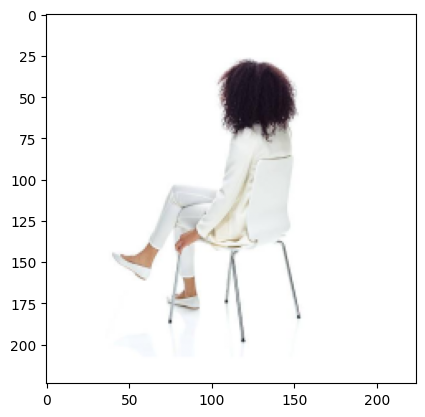

In [31]:

prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/12000_images/sitting_images/S387.jpg")


(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[[5.6036824e-04 9.9943906e-01 5.8037313e-07]]
Predicted class: standing
Confidence: 99.94%


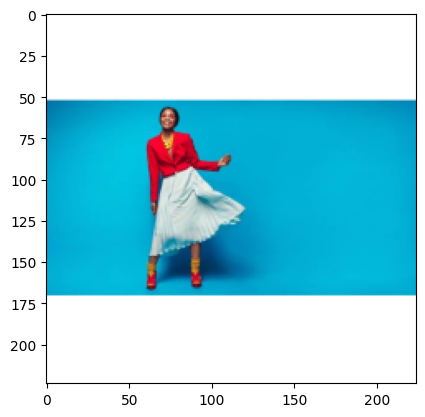

In [32]:


prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/12000_images/standing_images/S387.jpg")

(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[[2.1358052e-05 1.2065010e-05 9.9996662e-01]]
Predicted class: no people
Confidence: 100.00%


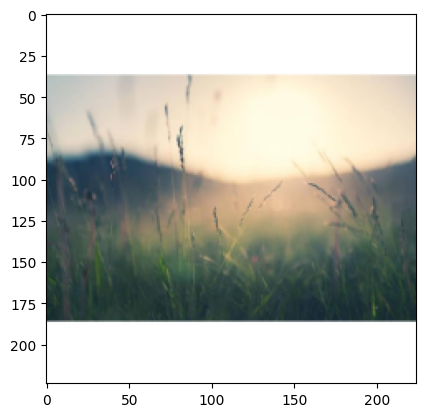

In [33]:

prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/12000_images/no_people/S31.jpg.jpg")

(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[[4.6356148e-13 1.8638095e-13 1.0000000e+00]]
Predicted class: no people
Confidence: 100.00%


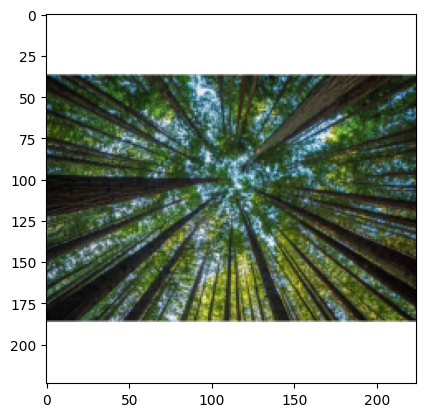

In [34]:

prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/12000_images/no_people/S387.jpg.jpg")

(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[0. 1. 0.]]
Predicted class: standing
Confidence: 100.00%


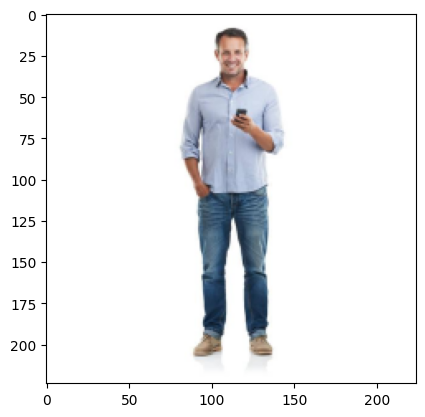

In [35]:

prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/12000_images/standing_images/S31.jpg")

(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[1.0000000e+00 1.3176112e-10 2.2129565e-10]]
Predicted class: sitting
Confidence: 100.00%


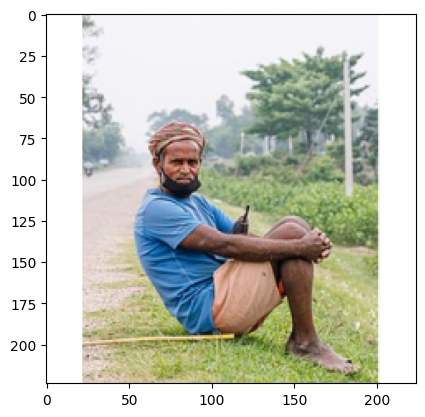

In [36]:

prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/A_man_sitting_on_the_back_of_Road_during_lockdown-Shambhunath_Municipality_,_Nepal-4556.jpg")


(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[[2.1718541e-04 5.9143399e-06 9.9977690e-01]]
Predicted class: no people
Confidence: 99.98%


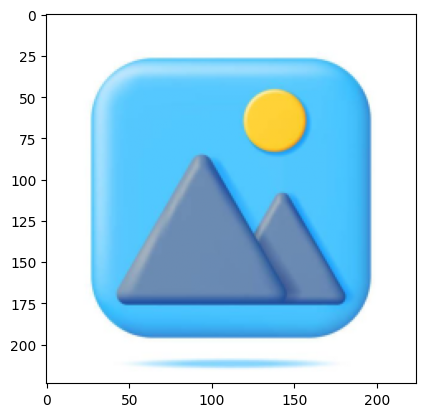

In [37]:

prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/12000_images/no_people/S4190.jpg.jpg")


(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[[1.4641812e-03 4.3045466e-06 9.9853146e-01]]
Predicted class: no people
Confidence: 99.85%


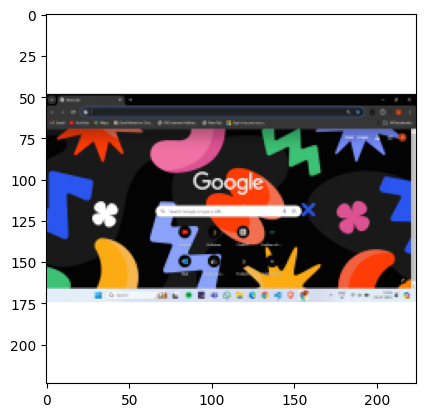

In [38]:
prediction("C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/google_screenshot.jpg")

#### Trying the model on some real images taken from Mobile Camera

In [49]:
test_df_sit = pd.DataFrame(
   { 'image': glob.glob('C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/testing__pics/sitting/*') ,
    'label': 'sitting'}
)
test_df_stand = pd.DataFrame(
   { 'image': glob.glob('C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/testing__pics/standing/*') ,
    'label': 'standing'}
)

test_df_other = pd.DataFrame(
   { 'image': glob.glob('C:/Users/91630/OneDrive - Indian Institute of Technology Guwahati/Desktop/testing__pics/no people/*'),
    'label': 'other'}
)

In [50]:
test_df=pd.concat([test_df_sit,test_df_stand,test_df_other])

In [51]:
test_df['target'] = test_df['label'].map({
    'sitting':0, 
    'standing':1,
    'other':2
})

In [52]:

test_df = test_df.sample(frac=1).reset_index(drop=True)

In [53]:
test_df

image     label  target
0   C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
1   C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
2   C:/Users/91630/OneDrive - Indian Institute of ...     other       2
3   C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
4   C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
5   C:/Users/91630/OneDrive - Indian Institute of ...     other       2
6   C:/Users/91630/OneDrive - Indian Institute of ...     other       2
7   C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
8   C:/Users/91630/OneDrive - Indian Institute of ...     other       2
9   C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
10  C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
11  C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
12  C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
13  C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
14  C:/Users/91630/OneDrive - Indian Institute of ...     other       2
15  C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
16  C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
17  C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
18  C:/Users/91630/OneDrive - Indian Institute of ...  standing       1
19  C:/Users/91630/OneDrive - Indian Institute of ...     other       2
20  C:/Users/91630/OneDrive - Indian Institute of ...   sitting       0
21  C:/Users/91630/OneDrive - Indian Institute of ...     other       2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


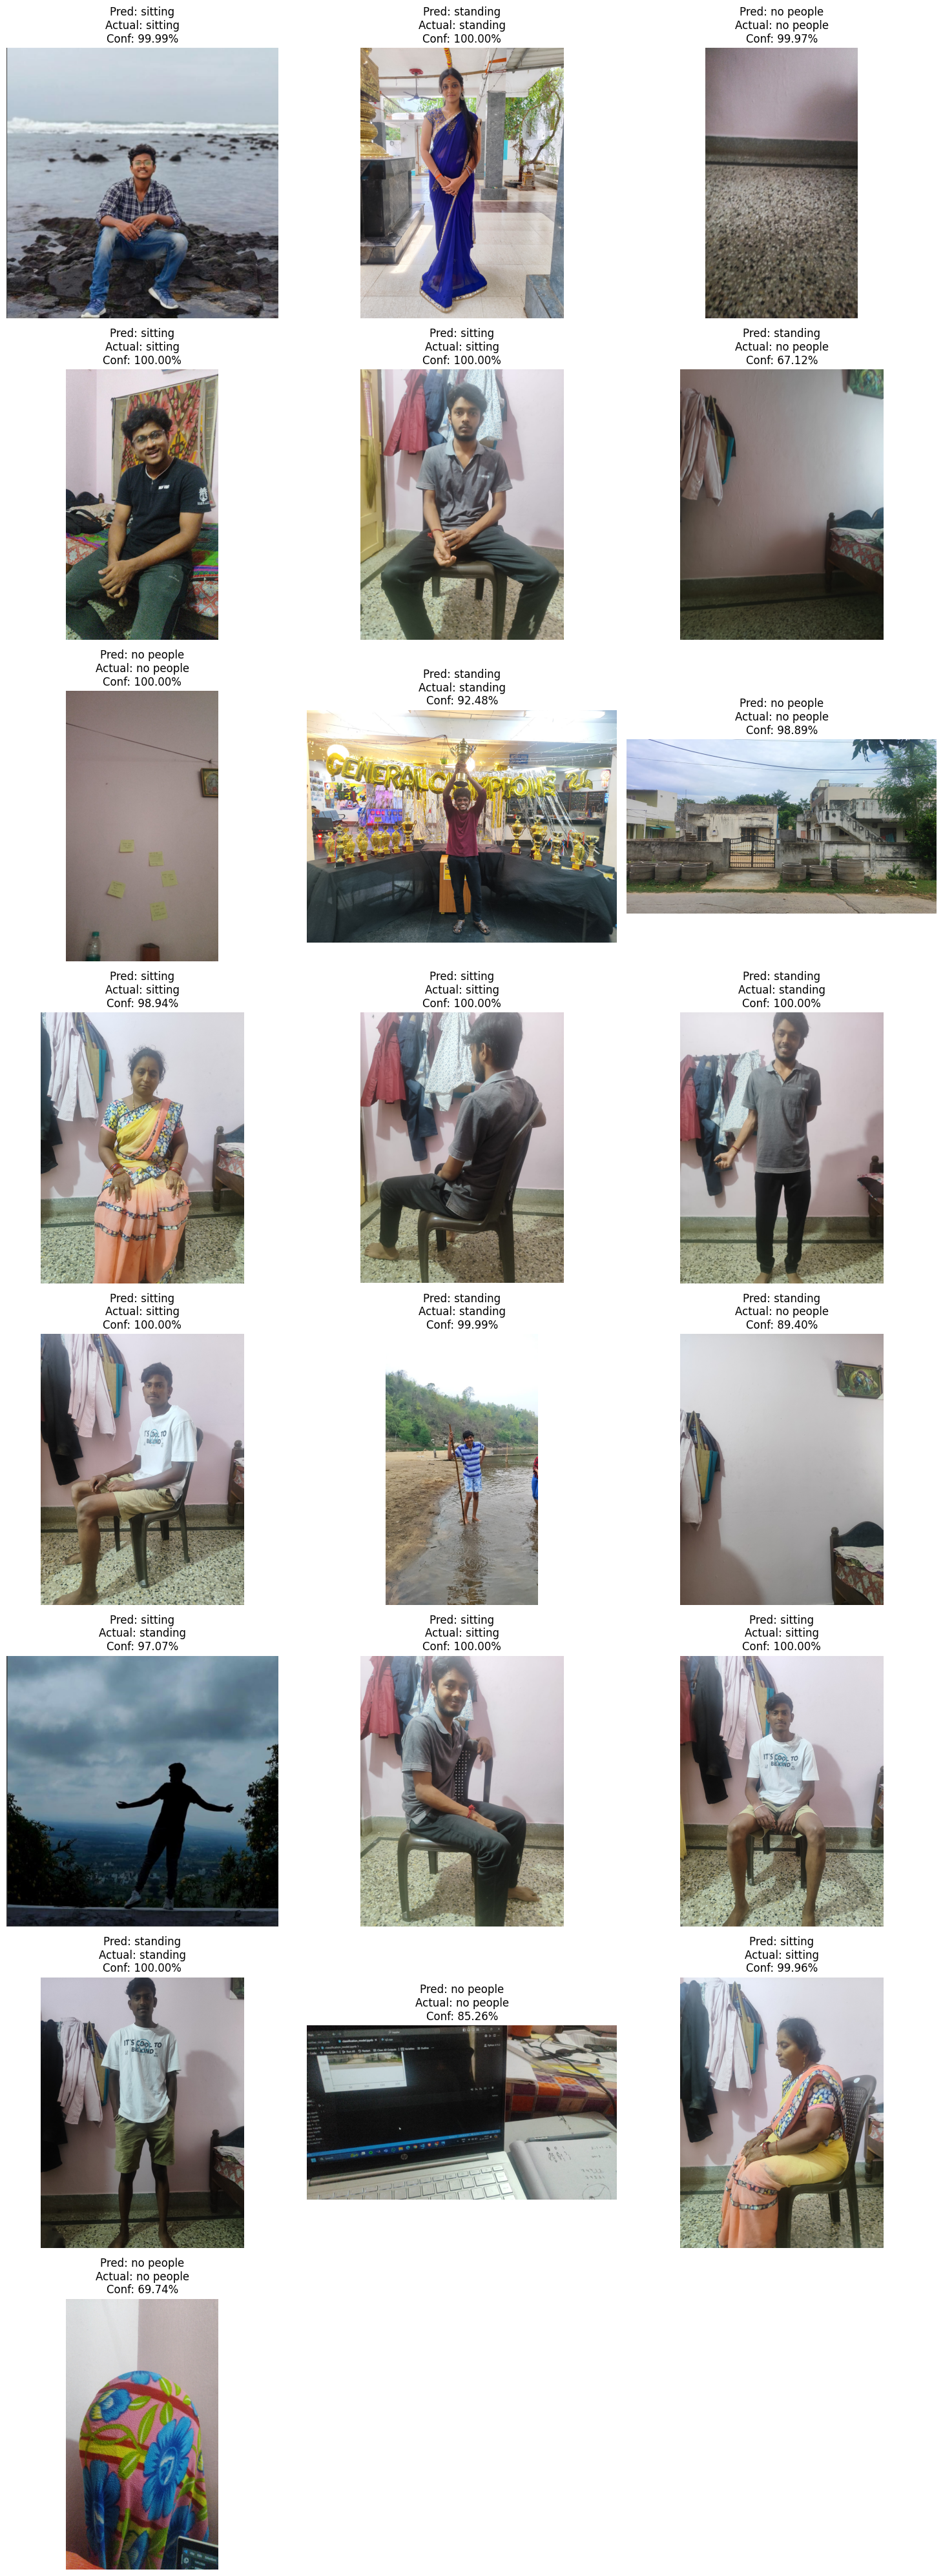

In [70]:

from PIL import Image

num_images = len(test_df)
num_cols = 3  
num_rows = num_images // num_cols + int(num_images % num_cols != 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for ax, (img_path, target) in zip(axes, zip(test_df['image'], test_df['target'])):
    img = Image.open(img_path) 
    img_array = load_and_preprocess_image(img_path)
    
    ax.imshow(img)
    ax.axis('off') 

    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    
    predicted_class = np.argmax(predictions)
    
    
    confidence = 100 * np.max(predictions)

    ax.set_title(f"Pred: {mapping[predicted_class]}\nActual: {mapping[target]}\nConf: {confidence:.2f}%")


for ax in axes[len(test_df):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


##### It can be seen that some images with low lights or some dense colored objects may sometimes disturb the prediction, else the prediction is fine